<a href="https://colab.research.google.com/github/annaceglarska/Predicting-cat-adoption/blob/main/Cat_adoption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikit-learn==1.5.2
%pip install keras_tuner
%pip install scikit_posthocs
%pip install mlxtend

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 21.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.7 MB/s eta 0:00:00


In [ ]:
import os
import pickle
import pandas as pd
import numpy as np
import tensorflow as tf
import keras_tuner as kt
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler

1. Analiza danych

Dane: https://www.kaggle.com/datasets/aaronschlegel/austin-animal-center-shelter-outcomes-and?select=aac_shelter_cat_outcome_eng.csv



Problem: Predykcja wieku kota, w którym zostanie wzięty ze schroniska na podstawie jego cech.
<p>Założenie: koty te od urodzenia znajdują się w schronisku.</p>

Wczytanie danych.

In [ ]:
adopted_cats_data = pd.read_csv("cat_shelter.csv", sep=';')
adopted_cats_data.head()

,outcome_type,sex,Spay/Neuter,Period Range,outcome_age_(days),Cat/Kitten (outcome),cfa_breed,domestic_breed,coat_pattern,color1,color2,coat,breed1,breed2
0,Transfer,Male,No,7,14,Kitten,False,True,tabby,orange,NaN,orange,domestic shorthair,NaN
1,Adoption,Female,No,30,30,Kitten,False,True,tabby,blue,white,blue,domestic shorthair,NaN
2,Adoption,Female,Yes,30,90,Kitten,False,True,NaN,white,black,white,domestic shorthair,NaN
3,Return to Owner,Female,Yes,365,365,Cat,False,True,NaN,black,white,black,domestic mediumhair,NaN
4,Transfer,Male,No,7,21,Kitten,False,True,NaN,black,white,black,domestic shorthair,NaN


In [ ]:
adopted_cats_data['outcome_type'].unique()

array(['Transfer', 'Adoption', 'Return to Owner', 'Died', 'Euthanasia',
       'Missing', 'Disposal', 'Rto-Adopt', nan], dtype=object)

In [ ]:
# Usunięcie wszystkich wierszy, które w kolumnie "outcome_type" mają wartości: Died, Euthanasia, Missing, Return to Owner - zostawienie wierszy z wartościami Adoption, Disposal, Rto-Adopt, Transfer
adopted_cats_data = adopted_cats_data[adopted_cats_data['outcome_type'].isin(['Adoption', 'Disposal', 'Rto-Adopt', 'Transfer'])]

# Sprawdzamy, czy dane zostały poprawnie usunięte
assert len(adopted_cats_data[adopted_cats_data['outcome_type'].isin(['Died', 'Euthanasia', 'Missing', 'Return to Owner'])]) == 0

# Sprawdzenie danych
adopted_cats_data.info()
print(adopted_cats_data.isnull().sum())
print(f"Ilość wierszy: {adopted_cats_data.shape[0]}")

# Po tym zabiegu kolumna 'outcome_type' nie jest już nam potrzebna - w przewidywaniach nie będziemy rozróżniać typu adopcji
adopted_cats_data = adopted_cats_data.drop(columns=['outcome_type'])

<class 'pandas.core.frame.DataFrame'>
Index: 26104 entries, 0 to 29420
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   outcome_type          26104 non-null  object
 1   sex                   26104 non-null  object
 2   Spay/Neuter           26104 non-null  object
 3   Period Range          26104 non-null  int64 
 4   outcome_age_(days)    26104 non-null  int64 
 5   Cat/Kitten (outcome)  26104 non-null  object
 6   cfa_breed             26104 non-null  bool  
 7   domestic_breed        26104 non-null  bool  
 8   coat_pattern          17107 non-null  object
 9   color1                26104 non-null  object
 10  color2                9138 non-null   object
 11  coat                  26104 non-null  object
 12  breed1                26104 non-null  object
 13  breed2                45 non-null     object
dtypes: bool(2), int64(2), object(10)
memory usage: 2.6+ MB
outcome_type                0
sex   

In [ ]:
print(adopted_cats_data['coat_pattern'].value_counts())

coat_pattern
tabby       12147
tortie       1394
calico       1353
point        1112
torbie        945
smoke         145
agouti          5
brindle         4
tricolor        2
Name: count, dtype: int64


In [ ]:
adopted_cats_data['coat_pattern'].fillna(adopted_cats_data['coat_pattern'].mode()[0], inplace=True)

<ipython-input-7-fc38f924d2a3>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  adopted_cats_data['coat_pattern'].fillna(adopted_cats_data['coat_pattern'].mode()[0], inplace=True)


In [ ]:
print(adopted_cats_data['coat_pattern'].value_counts())

coat_pattern
tabby       21144
tortie       1394
calico       1353
point        1112
torbie        945
smoke         145
agouti          5
brindle         4
tricolor        2
Name: count, dtype: int64


In [ ]:
# Wartości null w kolumnach 'coat_pattern', 'color2', 'breed2' - wszystkie z wymienionych są to wartości typu string
# Bardzo dużo wartości brakuje w kolumnach 'color2' oraz 'breed2' - z tego powodu kolumny te nie będą brane pod uwagę - zostaną usunięte
adopted_cats_data = adopted_cats_data.drop(columns=['color2', 'breed2'])
adopted_cats_data.head()

,sex,Spay/Neuter,Period Range,outcome_age_(days),Cat/Kitten (outcome),cfa_breed,domestic_breed,coat_pattern,color1,coat,breed1
0,Male,No,7,14,Kitten,False,True,tabby,orange,orange,domestic shorthair
1,Female,No,30,30,Kitten,False,True,tabby,blue,blue,domestic shorthair
2,Female,Yes,30,90,Kitten,False,True,tabby,white,white,domestic shorthair
4,Male,No,7,21,Kitten,False,True,tabby,black,black,domestic shorthair
5,Female,Yes,30,60,Kitten,False,True,tabby,brown,brown,domestic shorthair


Przekształcanie danych: Dane opisowe (kategoryczne) przekształcane zostaną na one-hot encoding



In [ ]:
# zamiana danych opisowych na one-hot encoding
# korzystamy z  pd.get_dummies(), ponieważ stosujemy to do cech. Funkcja get_dummies() w pandas zamienia kolumnę, która ma wartości kategoryczne (np. coat_patter), na zestaw kolumn binarnych (jedną kolumnę na każdą unikalną wartość kategorii).
# drop_first=True: W tym przypadku jedna kolumna jest usuwana
# nie używamy tf.keras.utils.to_categorical() - używa się do zmiennej wyjściowej (przewidywanej), głównie do zakodowania klas

In [ ]:
# Czyszczenie danych

adopted_cats_data['color1'] = adopted_cats_data['color1'].str.lower()
adopted_cats_data['color1'] = adopted_cats_data['color1'].str.replace('\n', '', regex=True)
adopted_cats_data['color1'] = adopted_cats_data['color1'].str.strip()
color_types = adopted_cats_data['color1'].unique()
print(color_types)

for color in color_types:
  adopted_cats_data['color1'] = adopted_cats_data['color1'].apply(lambda color_value: color if color in color_value.split()[0] else color_value)

threshold = 100
adopted_cats_data['color1'] = adopted_cats_data['color1'].apply(
    lambda x: x if adopted_cats_data['color1'].value_counts()[x] >= threshold else 'other'
)

print(adopted_cats_data['color1'].value_counts())




['orange' 'blue' 'white' 'black' 'brown' 'seal' 'breed specific' 'cream'
 'chocolate' 'silver' 'flame' 'lynx' 'lilac' 'buff' 'blue cream'
 'silver lynx' 'gray' 'apricot' 'brown tiger' 'tan' 'yellow' 'sable'
 'pink' 'brown merle' 'fawn']
color1
black             6302
brown             6172
breed specific    3677
blue              3270
orange            2991
white             1480
cream              728
lynx               425
seal               309
gray               299
flame              182
other              167
silver             102
Name: count, dtype: int64


In [ ]:
threshold_breed = 500

adopted_cats_data['coat_pattern'] = adopted_cats_data['coat_pattern'].apply(
    lambda x: x if adopted_cats_data['coat_pattern'].value_counts()[x] >= threshold_breed else 'other'
)

In [ ]:
adopted_cats_data['breed1'] = adopted_cats_data['breed1'].str.lower()
adopted_cats_data['breed1'] = adopted_cats_data['breed1'].str.replace('\n', '', regex=True)
adopted_cats_data['breed1'] = adopted_cats_data['breed1'].str.strip()

threshold_breed = 500

adopted_cats_data['breed1'] = adopted_cats_data['breed1'].apply(
    lambda x: x if adopted_cats_data['breed1'].value_counts()[x] >= threshold_breed else 'other'
)

In [ ]:
print("Sex")
print(adopted_cats_data['sex'].value_counts())
print("Spay/Neuter")
print(adopted_cats_data['Spay/Neuter'].value_counts())
print("Cat/Kitten (outcome)")
print(adopted_cats_data['Cat/Kitten (outcome)'].value_counts())
print("cfa_breed")
print(adopted_cats_data['cfa_breed'].value_counts())
print("outcome_age_(days)")
print(adopted_cats_data['outcome_age_(days)'].value_counts())


Sex
sex
Female    14551
Male      11553
Name: count, dtype: int64
Spay/Neuter
Spay/Neuter
Yes    18026
No      8078
Name: count, dtype: int64
Cat/Kitten (outcome)
Cat/Kitten (outcome)
Kitten    16381
Cat        9723
Name: count, dtype: int64
cfa_breed
cfa_breed
False    24621
True      1483
Name: count, dtype: int64
outcome_age_(days)
outcome_age_(days)
60      5783
365     3058
90      2346
730     1991
30      1675
21      1323
120     1283
14      1124
1095     779
7        747
150      647
28       640
180      570
1460     394
1825     380
2920     300
240      299
210      294
2190     265
300      241
2555     239
3650     205
3        202
270      140
2        137
3285     120
4        114
6        107
4380      98
1         96
330       82
4015      72
4745      71
5         70
5110      54
0         46
5475      41
35        41
5840      14
6205      11
7300       2
6570       2
6935       1
Name: count, dtype: int64


In [ ]:
threshold_age = 5500

adopted_cats_data['outcome_age_(days)'] = adopted_cats_data['outcome_age_(days)'].apply(
    lambda x: 6165 if x >= threshold_age else x
)

print("outcome_age_(days)")
print(adopted_cats_data['outcome_age_(days)'].value_counts())

outcome_age_(days)
outcome_age_(days)
60      5783
365     3058
90      2346
730     1991
30      1675
21      1323
120     1283
14      1124
1095     779
7        747
150      647
28       640
180      570
1460     394
1825     380
2920     300
240      299
210      294
2190     265
300      241
2555     239
3650     205
3        202
270      140
2        137
3285     120
4        114
6        107
4380      98
1         96
330       82
4015      72
4745      71
5         70
5110      54
0         46
5475      41
35        41
6165      30
Name: count, dtype: int64


In [ ]:
adopted_cats_data = pd.get_dummies(adopted_cats_data, columns=['sex', 'Spay/Neuter', 'Cat/Kitten (outcome)', 'color1', 'breed1', 'coat_pattern'], drop_first=True)
adopted_cats_data.head()

,Period Range,outcome_age_(days),cfa_breed,domestic_breed,coat,sex_Male,Spay/Neuter_Yes,Cat/Kitten (outcome)_Kitten,color1_blue,color1_breed specific,...,color1_white,breed1_domestic mediumhair,breed1_domestic shorthair,breed1_other,breed1_siamese,coat_pattern_other,coat_pattern_point,coat_pattern_tabby,coat_pattern_torbie,coat_pattern_tortie
0,7,14,False,True,orange,True,False,True,False,False,...,False,False,True,False,False,False,False,True,False,False
1,30,30,False,True,blue,False,False,True,True,False,...,False,False,True,False,False,False,False,True,False,False
2,30,90,False,True,white,False,True,True,False,False,...,True,False,True,False,False,False,False,True,False,False
4,7,21,False,True,black,True,False,True,False,False,...,False,False,True,False,False,False,False,True,False,False
5,30,60,False,True,brown,False,True,True,False,False,...,False,False,True,False,False,False,False,True,False,False


In [ ]:
print(adopted_cats_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 26104 entries, 0 to 29420
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Period Range                 26104 non-null  int64 
 1   outcome_age_(days)           26104 non-null  int64 
 2   cfa_breed                    26104 non-null  bool  
 3   domestic_breed               26104 non-null  bool  
 4   coat                         26104 non-null  object
 5   sex_Male                     26104 non-null  bool  
 6   Spay/Neuter_Yes              26104 non-null  bool  
 7   Cat/Kitten (outcome)_Kitten  26104 non-null  bool  
 8   color1_blue                  26104 non-null  bool  
 9   color1_breed specific        26104 non-null  bool  
 10  color1_brown                 26104 non-null  bool  
 11  color1_cream                 26104 non-null  bool  
 12  color1_flame                 26104 non-null  bool  
 13  color1_gray                  26104 n

In [ ]:
# ad.3 - rzutowanie zmiennych typów danych na int normalizacja danych numerycznych za pomocą MinMaxScaler()
columns = adopted_cats_data.columns
adopted_cats_data[columns] = adopted_cats_data[columns].astype(int)

minmax_scaler = MinMaxScaler()
columns_to_normalized = ['outcome_age_(days)']
adopted_cats_data[columns_to_normalized] = minmax_scaler.fit_transform(adopted_cats_data[columns_to_normalized])
adopted_cats_data[columns_to_normalized] = adopted_cats_data[columns_to_normalized].astype(np.float32)

adopted_cats_data.info()
print(adopted_cats_data.dtypes)
print(adopted_cats_data.shape)

ValueError: invalid literal for int() with base 10: 'orange'

In [ ]:
# Podział danych na treningowe i testowe
X, y = adopted_cats_data.drop(columns=['outcome_age_(days)']), adopted_cats_data['outcome_age_(days)']

# Podział danych na treningowe i testowe
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=123)

Budowa modelu

In [ ]:
def create_model():
  model = Sequential([

    BatchNormalization(input_dim=X.shape[1]),
    Dense(46, activation='relu'),
    Dense(23, activation='relu'),
    Dense(12, activation='relu'),
    Dense(1, activation='relu')
  ])

  model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mape', 'mse'])

  return model

In [ ]:
print(X_train.dtypes)
print(y_train.dtypes)

Trenowanie modelu

In [ ]:
main_model = create_model()
history = main_model.fit(X_train, y_train, epochs=70, batch_size=32)


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


653/653 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0145 - mae: 0.0561 - mape: 225098.4531 - mse: 0.0145
Epoch 2/100
653/653 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0113 - mae: 0.0514 - mape: 208017.0312 - mse: 0.0113
Epoch 3/100
653/653 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0103 - mae: 0.0488 - mape: 294711.4688 - mse: 0.0103
Epoch 4/100
653/653 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0101 - mae: 0.0478 - mape: 257509.3906 - mse: 0.0101
Epoch 5/100
653/653 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0099 - mae: 0.0471 - mape: 251647.7500 - mse: 0.0099
Epoch 6/100
653/653 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0101 - mae: 0.0476 - mape: 167174.2188 - mse: 0.0101
Epoch 7/100
653/653 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0099 - mae: 0.0466 - mape: 240974.1094 - mse: 0.0099
Epoch 8/100
653/653 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0102 - mae: 0.0471 - mape: 231322.6094 - mse: 0.0102
Epoch 9/100
653/653 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0099 - mae: 0.0464 - 

Sprawdzenie jakości modelu

In [ ]:
y_predict = main_model.predict(X_test)

mape_main_model = mean_absolute_percentage_error(y_test, y_predict)
mse_main_model = mean_squared_error(y_test, y_predict)

print(f"MAPE model2: {mape_main_model}")
print(f"MSE mdoel2: {mse_main_model}")

164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAPE model2: 1.2325290441513062
MSE mdoel2: 0.01157112792134285


Tunning sieci

In [ ]:
def complex_architecture_search(hp):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.BatchNormalization())

    hp_nlayers = hp.Int('nlayers', min_value=1, max_value=4, step=1)
    for l_idx in range(hp_nlayers):
        hp_units = hp.Int(f'units_layer_{l_idx}', min_value=4, max_value=46, step=2)
        hp_activations = hp.Choice(f'activation_layer_{l_idx}', values=['relu', 'tanh', 'softmax'])
        model.add(tf.keras.layers.Dense(hp_units, hp_activations, input_shape=(X_train.shape[1],)))
    model.add(tf.keras.layers.Dense(1, 'relu'))
    model.compile(optimizer='adam', loss='mean_absolute_percentage_error', metrics=['mean_absolute_error', 'mean_absolute_percentage_error', 'mse'])
    return model

In [ ]:
tuner = kt.Hyperband(complex_architecture_search,
                     objective=kt.Objective("val_mean_absolute_percentage_error", direction="min"),
                     max_epochs=70,
                     hyperband_iterations=5,
                     directory=os.path.normpath(os.path.join("/content/", "keras_tuner")),
                     project_name='tuner_regressor')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
tuner.search(
    X_train,
    y_train,
    epochs=70,
    validation_split=0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='mse', patience=5)])

Trial 450 Complete [00h 00m 40s]
val_mean_absolute_percentage_error: 99.78453063964844

Best val_mean_absolute_percentage_error So Far: 66.19427490234375
Total elapsed time: 03h 03m 46s


In [ ]:
best_params = tuner.get_best_hyperparameters()[0]
for i in range(best_params.get('nlayers')):
    print(f"Layer {i}, activation:", best_params.get(f'activation_layer_{i}'), "units: ", best_params.get(f'units_layer_{i}'))

Layer 0, activation: relu units:  34
Layer 1, activation: relu units:  42
Layer 2, activation: softmax units:  22
Layer 3, activation: relu units:  14


In [ ]:
def tuner_builder():
    model = tuner.hypermodel.build(best_params)
    return model

In [ ]:
tuner_model = tuner_builder()

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1306/1306 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 99.7337 - mean_absolute_error: 0.0677 - mean_absolute_percentage_error: 99.7337 - mse: 0.0221
Epoch 2/5
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 99.7764 - mean_absolute_error: 0.0672 - mean_absolute_percentage_error: 99.7764 - mse: 0.0220
Epoch 3/5
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 99.8618 - mean_absolute_error: 0.0679 - mean_absolute_percentage_error: 99.8618 - mse: 0.0221
Epoch 4/5
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 99.7994 - mean_absolute_error: 0.0684 - mean_absolute_percentage_error: 99.7994 - mse: 0.0228
Epoch 5/5
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 99.7785 - mean_absolute_error: 0.0679 - mean_absolute_percentage_error: 99.7785 - mse: 0.0226


In [ ]:
model_path = '/content/optuna_model.pkl'

In [ ]:
# Zapisz model (np. po dostrojeniu)
with open('/content/optuna_model.pkl', 'wb') as f:
    pickle.dump(tuner_model, f)

In [ ]:
with open(model_path, 'rb') as file:
  check_tuner_model = pickle.load(file)

check_tuner_model.fit(X_train, y_train, epochs=70, batch_size=32)

Epoch 1/50
653/653 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 99.7867 - mean_absolute_error: 0.0686 - mean_absolute_percentage_error: 99.7867
Epoch 2/50
653/653 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 99.8101 - mean_absolute_error: 0.0687 - mean_absolute_percentage_error: 99.8101
Epoch 3/50
653/653 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 99.8639 - mean_absolute_error: 0.0666 - mean_absolute_percentage_error: 99.8639
Epoch 4/50
653/653 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 99.8294 - mean_absolute_error: 0.0685 - mean_absolute_percentage_error: 99.8294
Epoch 5/50
653/653 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 99.8300 - mean_absolute_error: 0.0662 - mean_absolute_percentage_error: 99.8300
Epoch 6/50
653/653 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 99.8281 - mean_absolute_error: 0.0680 - mean_absolute_percentage_error: 99.8281
Epoch 7/50
653/653 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 99.8277 - mean_absolute_error: 0.0676 - mean_absolute_percentage_error: 99.8277
Epoch 8/50
653/653 ━

In [ ]:
check_yhat_tuner = check_tuner_model.predict(X_test)
print(f"MAPE final: {mean_absolute_percentage_error(y_test, check_yhat_tuner)}")
print(f"MSE final: {mean_squared_error(y_test, check_yhat_tuner)}")

164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAPE final: 0.9988508224487305
MSE final: 0.023512711748480797


Porównanie z inną metodą ML (Regresja Drzew Decyzyjnych i SVM)


In [ ]:
%pip install scikeras

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import scikeras.wrappers as sk_wrappers

In [ ]:
splitter = KFold(n_splits=10, random_state=123, shuffle=True)
print(y_train)

25844    0.009732
28095    0.177616
1719     0.009732
18564    0.003406
15856    0.014599
           ...   
17430    0.118410
24389    0.003406
20061    0.059205
17817    0.009732
22566    0.059205
Name: outcome_age_(days), Length: 20883, dtype: float32


In [ ]:
# regresja logistyczna
random_forest = RandomForestRegressor()
svm = SVR()

random_forest_cv = cross_val_score(random_forest, X_train, y_train, scoring='neg_mean_squared_error', cv=splitter)
svm_cv = cross_val_score(svm, X_train, y_train, scoring='neg_mean_squared_error', cv=splitter)

In [ ]:
with open(model_path, 'rb') as file:
  check_tuner_model = pickle.load(file)

In [ ]:
nn_wrapper = sk_wrappers.KerasRegressor(create_model, epochs=10, batch_size=32, verbose=0)
nn_cv = cross_val_score(nn_wrapper, X_train, y_train, scoring='neg_mean_squared_error', cv=splitter)

nn_tuner_wrapper = sk_wrappers.KerasRegressor(check_tuner_model, epochs=10, batch_size=32, verbose=0)
nn_tuner_cv = cross_val_score(nn_tuner_wrapper, X_train, y_train, scoring='neg_mean_squared_error', cv=splitter)

cv_results = {
    'Random Forest': random_forest_cv,
    'SVM': svm_cv,
    'NN': nn_cv,
    'NN_Tuner': nn_cv
}
cv_scores_df = pd.DataFrame.from_dict(cv_results)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/normali

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
print(cv_scores_df)

   Random Forest       SVM        NN  NN_Tuner
0      -0.010140 -0.010591 -0.014753 -0.014753
1      -0.011322 -0.012326 -0.017335 -0.017335
2      -0.011291 -0.011758 -0.021959 -0.021959
3      -0.010914 -0.011660 -0.021154 -0.021154
4      -0.012229 -0.012965 -0.016663 -0.016663
5      -0.010595 -0.010982 -0.021018 -0.021018
6      -0.011806 -0.012533 -0.022522 -0.022522
7      -0.012747 -0.013747 -0.024881 -0.024881
8      -0.011070 -0.012038 -0.019654 -0.019654
9      -0.012700 -0.013432 -0.025567 -0.025567


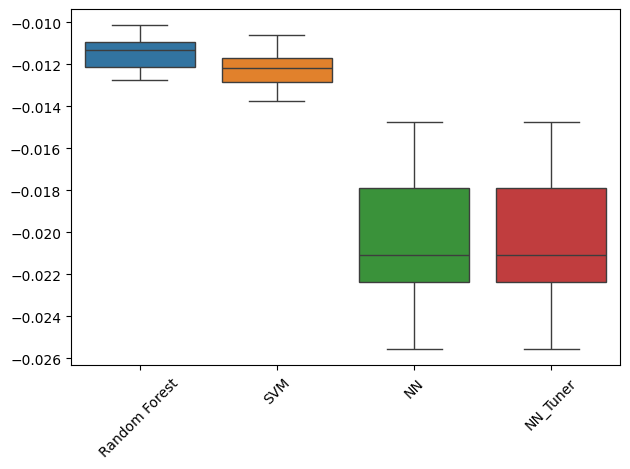

In [ ]:
sns.boxplot(data=cv_scores_df)
plt.xticks(rotation=45)
plt.tight_layout()

In [ ]:
stat, pval = st.friedmanchisquare(*cv_results.values())

In [ ]:
stat, pval # Mamy istotne różnice w modelach

(30.0, 1.3800570312932553e-06)

In [ ]:
sp.posthoc_conover_friedman(cv_scores_df, p_adjust='holm')

/usr/local/lib/python3.11/dist-packages/scikit_posthocs/_posthocs.py:734: RuntimeWarning: divide by zero encountered in scalar divide
  tval = dif / np.sqrt(A) / np.sqrt(B)
/usr/local/lib/python3.11/dist-packages/scikit_posthocs/_posthocs.py:734: RuntimeWarning: invalid value encountered in scalar divide
  tval = dif / np.sqrt(A) / np.sqrt(B)


,Random Forest,SVM,NN,NN_Tuner
Random Forest,1.0,0.0,0.0,0.0
SVM,0.0,1.0,0.0,0.0
NN,0.0,0.0,1.0,NaN
NN_Tuner,0.0,0.0,NaN,1.0


In [ ]:
with open(model_path, 'rb') as file:
  check_tuner_model = pickle.load(file)

In [ ]:
random_forest = RandomForestRegressor()
svm = SVR()
nn = create_model()
nn_tuner = check_tuner_model

random_forest_history = random_forest.fit(X_train, y_train)
svm_history = svm.fit(X_train, y_train)
nn_history = nn.fit(X_train, y_train)
nn_tuner_history = nn_tuner.fit(X_train, y_train)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


653/653 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0182 - mae: 0.0628 - mape: 3479.9226 - mse: 0.0182
653/653 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 99.8053 - mean_absolute_error: 0.0669 - mean_absolute_percentage_error: 99.8053


In [ ]:
y_predict_random_forest = random_forest.predict(X_test)
y_predict_svm = svm.predict(X_test)
y_predict_nn = nn.predict(X_test)
y_predict_nn_tuner = np.argmax(nn_tuner.predict(X_test), axis=1)

164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [ ]:
ml_results = {
    'Random Forest': y_predict_random_forest,
    'SVM': y_predict_svm,
    'NN': y_predict_nn.flatten(),
    'NN Tuner': y_predict_nn_tuner
}
clf_pred = pd.DataFrame.from_dict(ml_results)

print(clf_pred)

      Random Forest       SVM        NN  NN Tuner
0          0.177815  0.159063  0.135179         0
1          0.005958  0.050601  0.000000         0
2          0.009082 -0.016638  0.000000         0
3          0.006051  0.050380  0.000000         0
4          0.096125  0.128886  0.055422         0
...             ...       ...       ...       ...
5216       0.012647 -0.023894  0.000000         0
5217       0.098304  0.129018  0.135104         0
5218       0.188610  0.158993  0.173344         0
5219       0.007296  0.046656  0.000000         0
5220       0.005851  0.045836  0.000000         0

[5221 rows x 4 columns]


In [ ]:
from mlxtend.evaluate import mcnemar, mcnemar_table, f_test, mcnemar_tables

In [ ]:
stat, pval = f_test.ftest(
    y_test.values,
    clf_pred['Random Forest'].values,
    clf_pred['SVM'].values,
    clf_pred['NN'].values,
    clf_pred['NN Tuner'].values
)

In [ ]:
pval

0.00043829042399763017

In [ ]:
for name, tab in mcnemar_tables(y_test, clf_pred['Random Forest'].values,
    clf_pred['SVM'].values,
    clf_pred['NN Tuner'].values,
    clf_pred['NN'].values).items():
    stat, pval = mcnemar(tab, exact=True, corrected=True)
    print(f"{name} pval: {np.round(pval, 4)}", )

model_0 vs model_1 pval: 1.0
model_0 vs model_2 pval: 0.0312
model_0 vs model_3 pval: 0.0312
model_1 vs model_2 pval: 0.0312
model_1 vs model_3 pval: 0.0312
model_2 vs model_3 pval: 1.0
